# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Lab assignment №2
## Gradient boosting and model analysis

Today we will work with Gradient Boosting library. It is one of the most popular models these days that shows both great quality and performance.

Choises for library are:

* [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. Handful and fast.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

**Dataset**

By default we will work with widely known [Human Actividy Recognition (HAR) dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones). Data is available at UCI repository.

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.
Some simple preprocessing is done for you.

If you want more interpretable data, you can take [Wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) (see details below).

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian if it's more convenient for you._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [ ]:
# Download and unpack dataset from UCI
# !wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
# !unzip -q -u "UCI HAR Dataset.zip"

--2025-05-13 14:12:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Распознаётся archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Подключение к archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: нет данных
Сохранение в: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [                <=> ]  58,17M   922KB/s    за 2m 17s  

2025-05-13 14:15:03 (434 KB/s) - ‘UCI HAR Dataset.zip’ сохранён [60999314]



In [2]:
from pathlib import Path
from typing import Union

import matplotlib.pyplot as plt
import numpy as np

In [3]:
def read_har_labels(path: Path) -> dict[int, str]:
    labels = {}
    with path.open() as file:
        for line in file:
            label, name = line.strip().split(" ")
            labels[int(label)] = name

    return labels


def read_har(path: Union[str, Path]) -> tuple:
    path = Path(path)

    activity_labels = read_har_labels(path / "activity_labels.txt")
    feature_labels = read_har_labels(path / "features.txt")

    X_train = np.genfromtxt(path / "train/X_train.txt")
    y_train = np.genfromtxt(path / "train/y_train.txt")
    X_test = np.genfromtxt(path / "test/X_test.txt")
    y_test = np.genfromtxt(path / "test/y_test.txt")

    return activity_labels, feature_labels, X_train, y_train, X_test, y_test

In [4]:
activity_labels, feature_labels, X_train, y_train, X_test, y_test = read_har("UCI HAR Dataset")
n_features = X_train.shape[1]

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")
print("Activity labels: ", activity_labels)


Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)
Activity labels:  {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


In [5]:
np.unique(y_test)

array([1., 2., 3., 4., 5., 6.])

### Alternative dataset: Wine quality

Please, take this dataset if you are sure you can preprocess it yourself and ready to work with it's features and results.

However you will have more interpretable features which can be analysed with shap in last part.

In [6]:
# %pip install ucimlrepo

In [ ]:
# import ucimlrepo as uci

In [9]:
# dataset = uci.fetch_ucirepo(id=186)

# print(dataset.metadata.name, '\n')
# print(dataset.metadata.abstract, '\n')
# print(dataset.metadata.additional_info.summary, '\n')

### Analyse and preprocess data

First you need to analyse data you have (including performing EDA in a section below).

Get insights on the data you have by calculating basic statistics, plotting data and so on.

_Tip: data may contain some nasty artefacts. So, don't hesitate to deal with them._

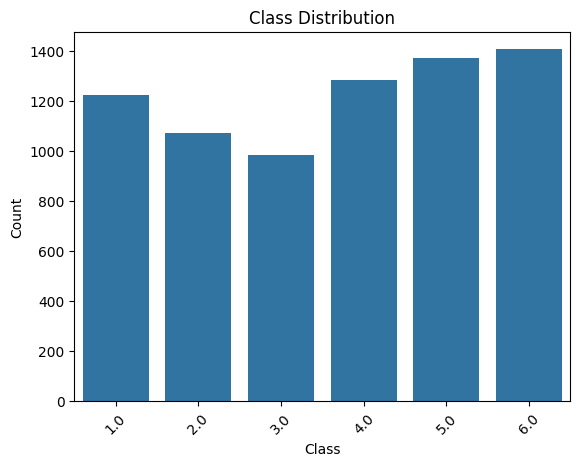

In [10]:
# YOUR CODE HERE
# Visualize the distribution of the target variable (labels)
import seaborn as sns

sns.countplot(x=y_train)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

The classes are distributed approximately equally. This suggests that the model won't suffer much from class imbalance, making it easier to train.



Apply PCA to the data

In [11]:
from sklearn.decomposition import PCA

In [12]:
# YOUR CODE HERE
# Apply PCA to reduce the dimensionality to 5 components
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca.shape, X_test_pca.shape

((7352, 5), (2947, 5))

In [13]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [14]:
activity_labels[1]

'WALKING'

Text(0, 0.5, 'Principal component 2')

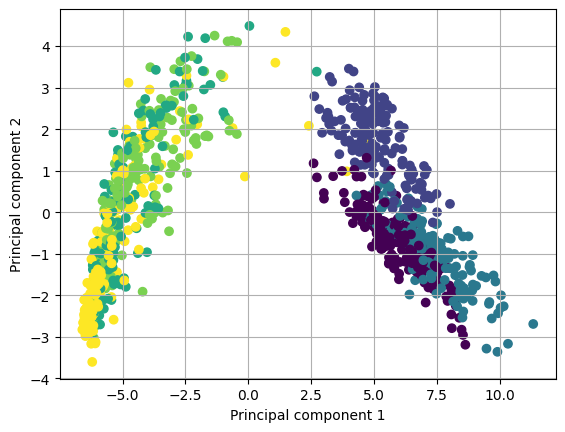

In [15]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

PCA has successfully captured the underlying structure of the data in a reduced form.

Text(0, 0.5, 'Principal component 5')

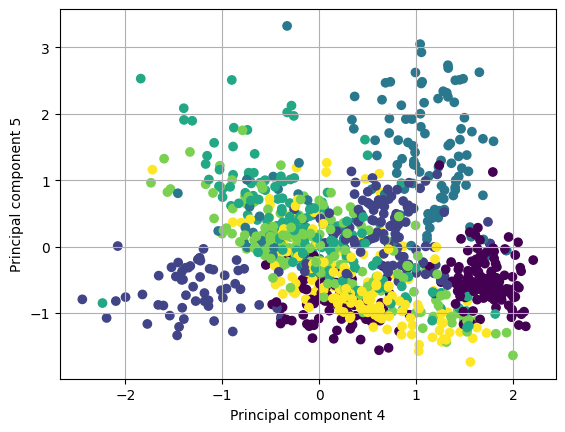

In [16]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

## Part 1: Fit the model

Rough example for that part: https://rpubs.com/burakh/har_xgb

Write basic model building and validation procedure. At this point you don't need to pick hyperparameters intensively. You may check a few by hand if you want. Use original feature set.

In [17]:
# YOUR CODE HERE
y_train -= 1  # Ensures that labels start from 0
y_test -= 1
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Prepare the data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for the model
params = {
    "objective": "multi:softmax",
    "num_class": len(activity_labels),
    "eval_metric": "merror"
}

# Train the model
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predict and evaluate the model
y_pred = bst.predict(dtest)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Test accuracy: 93.93%


### Metrics and plots

Calculate metrics for classification problem which we discussed on lecture.

Plot visualizations needed.

In [20]:
# YOUR CODE HERE

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Классификационный отчет
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[activity_labels[i+1] for i in range(len(activity_labels))]))



Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.93      0.98      0.95       496
  WALKING_UPSTAIRS       0.93      0.93      0.93       471
WALKING_DOWNSTAIRS       0.96      0.91      0.94       420
           SITTING       0.94      0.86      0.90       491
          STANDING       0.89      0.95      0.92       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



Модель XGBoost без тюнинга гиперпараметров демонстрирует высокую общую точность ≈ 93.9 %.

* Наилучший результат по F1-score показал класс LAYING (1.00), он практически не путается с другими.

* WALKING_DOWNSTAIRS и SITTING чуть хуже: по ним наблюдается небольшое снижение recall (0.91 и 0.86 соответственно), 

    модель иногда путает их с WALKING_UPSTAIRS или STANDING.
* Наименее хорошо распознаётся STANDING с precision 0.89, но при этом recall 0.95 — то есть большинство «стоящих» 
   
    примеров модель всё же правильно находит, но часть примеров отнесены к нему ошибочно.

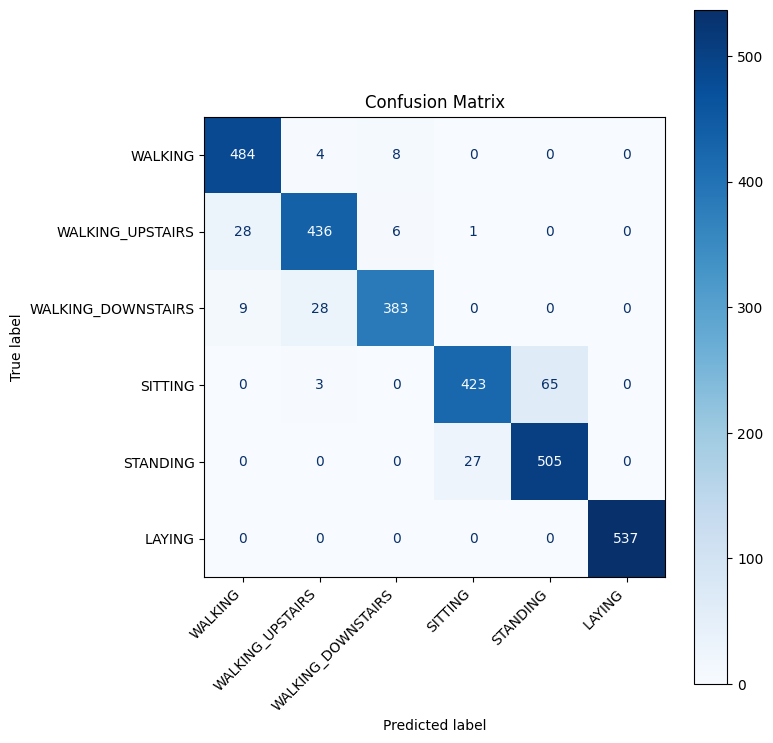

In [ ]:
# 2. Матрица неточностей (confusion matrix)
cm = confusion_matrix(y_test, y_pred)
labels = [activity_labels[i+1] for i in range(len(activity_labels))]

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap="Blues", values_format='d')

# Поворачиваем подписи по оси X
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Матрица неточностей

Основные «путаницы» происходят между парами WALKING_UPSTAIRS ↔ WALKING_DOWNSTAIRS и SITTING ↔ STANDING.
* Между активностями, в которых тело движется вертикально (подъём/спуск по лестнице), модель действительно путается чаще, что ожидаемо из-за схожести акселерометрических сигналов.
* Для сидения и стояния заметен смещение: часть сидящих точек модель классифицирует как стоящих (65 случаев).

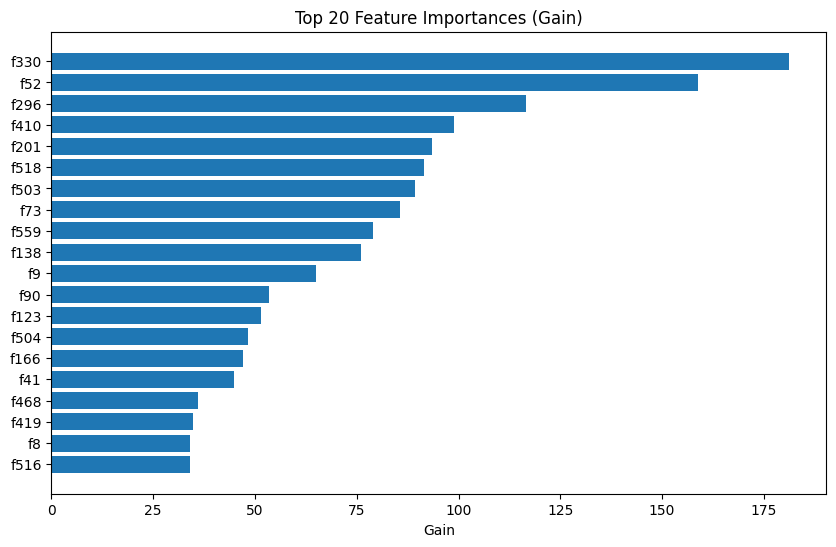

In [37]:
# 3. Важность признаков (feature importance) — доп. визуализация для Gradient Boosting
# топ-20 признаков по важности.
importances = bst.get_score(importance_type="gain")
# Сортируем по убыванию важности
sorted_feats = sorted(importances.items(), key=lambda x: x[1], reverse=True)[:20]
feat_names, feat_scores = zip(*sorted_feats)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feat_scores))[::-1], feat_scores, tick_label=feat_names)
plt.xlabel("Gain")
plt.title("Top 20 Feature Importances (Gain)")
plt.show()

# Важность признаков (gain)

Топ-3 признака по суммарному приросту (gain) оказались f330, f52 и f296.
Довольно много дублирующихся признаков (например, f503, f504, f518), которые имеют высокий вес: это подтверждает, что в данных есть сильно коррелированные группы признаков.


### Conclusion on basic model results

Describe what do you see in data you acquired, what can you say about that model?

**YOUR TEXT HERE**

***Итог: даже без серьёзного подбора параметров модель показывает хорошее качество (> 90 %) и справляется с основными активностями. Основные слабые места — распознавание близких по сигналу активностей (вверх/вниз по лестнице, сидячее/стоячее положение).***

 В дальнейшем стоит:

1. Провести гиперпараметрический тюнинг, чтобы подтянуть точность по «трудным» классам.
2. Рассмотреть удаление или агрегацию дублирующихся признаков, чтобы снизить сложность модели и улучшить её обобщающую способность.


## Part 2: Use hyper parameter tuning system

Use [optuna](https://optuna.org/) or [hyperopt](http://hyperopt.github.io/hyperopt/) zero order optimizer to find optimal hyper param set.

In [41]:
# YOUR CODE HERE
import optuna
import xgboost as xgb

# Подготовка DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

def objective(trial):
    num_rounds = trial.suggest_int("num_boost_round", 50, 500)
    param = {
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "num_class": len(activity_labels),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
    }

    cv_results = xgb.cv(
        params=param,
        dtrain=dtrain,
        num_boost_round=num_rounds,
        nfold=3,
        stratified=True,
        seed=42,
        early_stopping_rounds=20,
        metrics="merror",
        as_pandas=True,
        verbose_eval=False,
    )

    return cv_results["test-merror-mean"].min()
# Запускаем исследование
study = optuna.create_study(direction="minimize", study_name="xgb_har")
study.optimize(objective, n_trials=50, timeout=600)

print("Best merror:", study.best_value)
print("Best params:", study.best_params)

[I 2025-05-14 10:55:59,723] A new study created in memory with name: xgb_har


[I 2025-05-14 10:58:34,524] Trial 0 finished with value: 0.033596560615270187 and parameters: {'num_boost_round': 335, 'max_depth': 4, 'learning_rate': 0.008423581904537077, 'subsample': 0.9578779253265639, 'colsample_bytree': 0.95253510097108, 'alpha': 2.0847735122032047e-08, 'lambda': 0.0006377750055241722}. Best is trial 0 with value: 0.033596560615270187.
[I 2025-05-14 10:59:55,921] Trial 1 finished with value: 0.012921950501947005 and parameters: {'num_boost_round': 299, 'max_depth': 10, 'learning_rate': 0.10604349324021514, 'subsample': 0.9630382402236924, 'colsample_bytree': 0.7492338482042726, 'alpha': 3.6122048698506593e-07, 'lambda': 8.258077608817898e-07}. Best is trial 1 with value: 0.012921950501947005.
[I 2025-05-14 11:00:36,379] Trial 2 finished with value: 0.03005975625664382 and parameters: {'num_boost_round': 347, 'max_depth': 9, 'learning_rate': 0.0037697892902456122, 'subsample': 0.8301572004837144, 'colsample_bytree': 0.7842921482131981, 'alpha': 1.8420722743772356

Best merror: 0.010609191861158987
Best params: {'num_boost_round': 147, 'max_depth': 5, 'learning_rate': 0.18861352306178053, 'subsample': 0.7861797154519, 'colsample_bytree': 0.8595529904108999, 'alpha': 0.39279985365932707, 'lambda': 4.114925220709353e-07}


### Conclusion

Please, write down your thoughts on the experiment results (which hparams are more important than others, which improve did you get, etc):

**YOUR TEXT HERE**

## Part 3. Interpret the model predictions

Train model with the best hparams you've found and analyze it.

Please use [shap](https://github.com/slundberg/shap) to build beeswarm plot and at least one more of your choice and interpret them (in a conclusion section below).

Feature names were presented in dataset loading function.|

/home/andrej/study/girafe/.venv/lib/python3.12/site-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/home/andrej/study/girafe/.venv/lib/python3.12/site-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/home/andrej/study/girafe/.venv/lib/python3.12/site-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/hom

<Figure size 640x480 with 0 Axes>

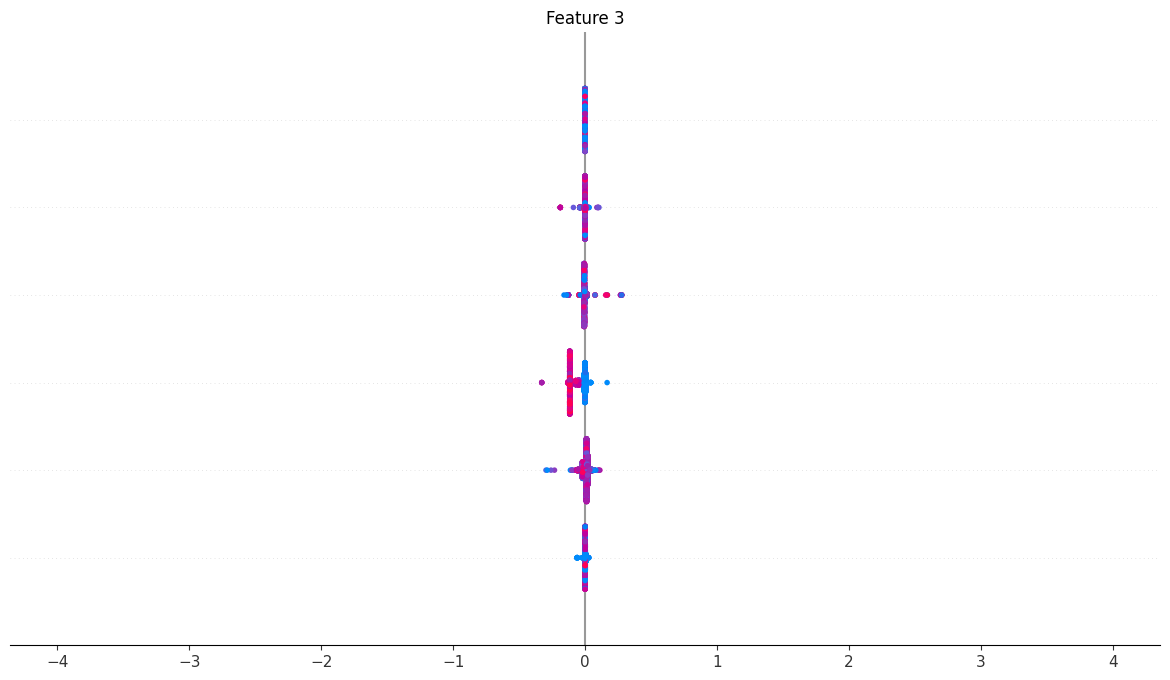

In [ ]:
# YOUR CODE HERE

import shap

feature_names=[feature_labels[i+1] for i in range(n_features)]

# 1) Подготовка финальных параметров и обучение
best_params = study.best_params.copy()
best_params.update({
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "num_class": len(activity_labels),
})
best_params.pop("num_boost_round", None)

dtrain = xgb.DMatrix(X_train, label=y_train)
model = xgb.train(best_params, dtrain, num_boost_round=100)

# SHAP analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP Summary plot
shap.summary_plot(shap_values, X_test)


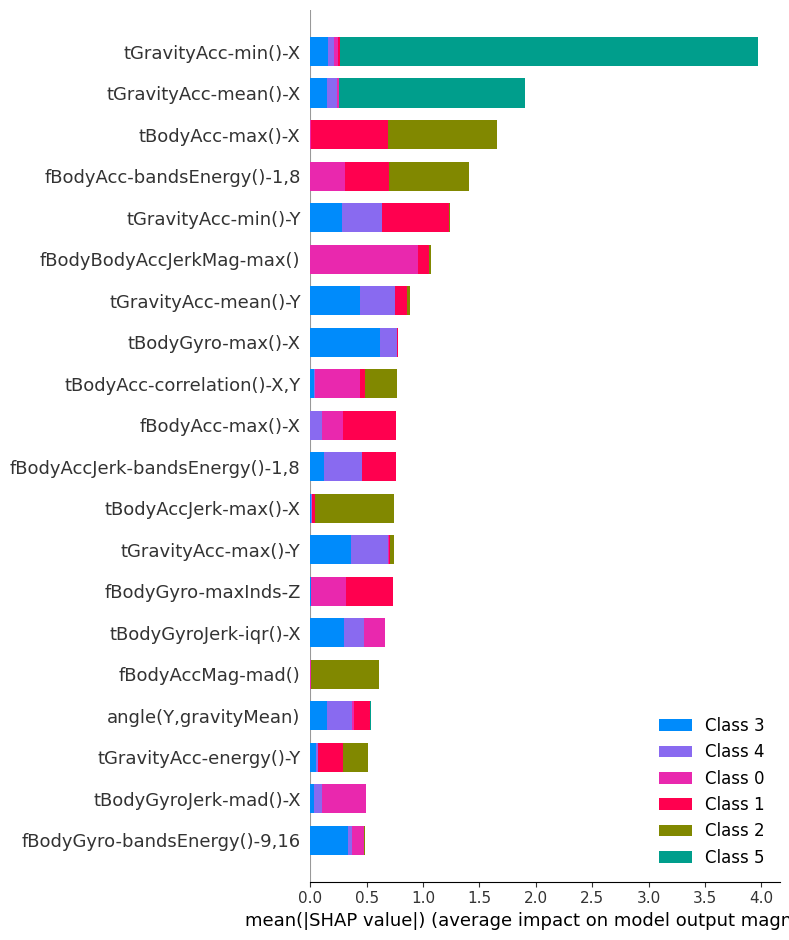

In [ ]:
# ——— Bar plot средней абсолютной важности ———
plt.figure(figsize=(8, 8))
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=feature_names,
    plot_type="bar",
    show=False,
    rng=0
)
plt.tight_layout()
plt.show()

_Tip for HAR_: there are duplicating features. You may describe their behaviour as part of conclusion.

In [60]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

Accuracy без дубликатов: 0.9440108585001696


/home/andrej/study/girafe/.venv/lib/python3.12/site-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/home/andrej/study/girafe/.venv/lib/python3.12/site-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/home/andrej/study/girafe/.venv/lib/python3.12/site-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/hom

<Figure size 800x600 with 0 Axes>

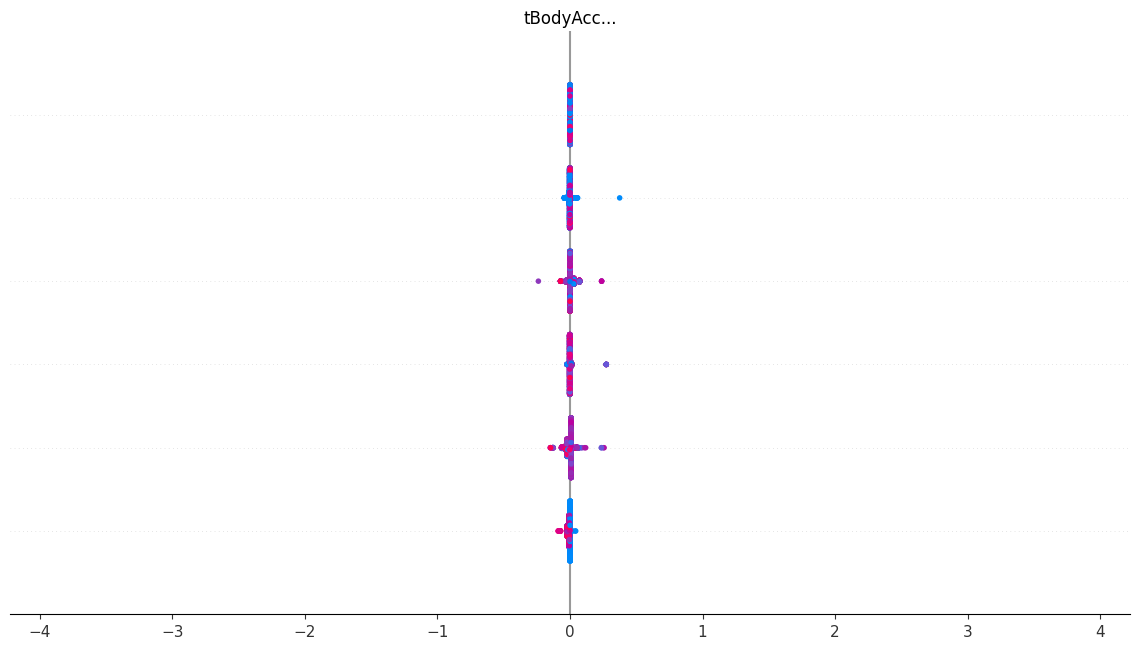

/tmp/ipykernel_6233/2739851030.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_nd, X_test_nd,


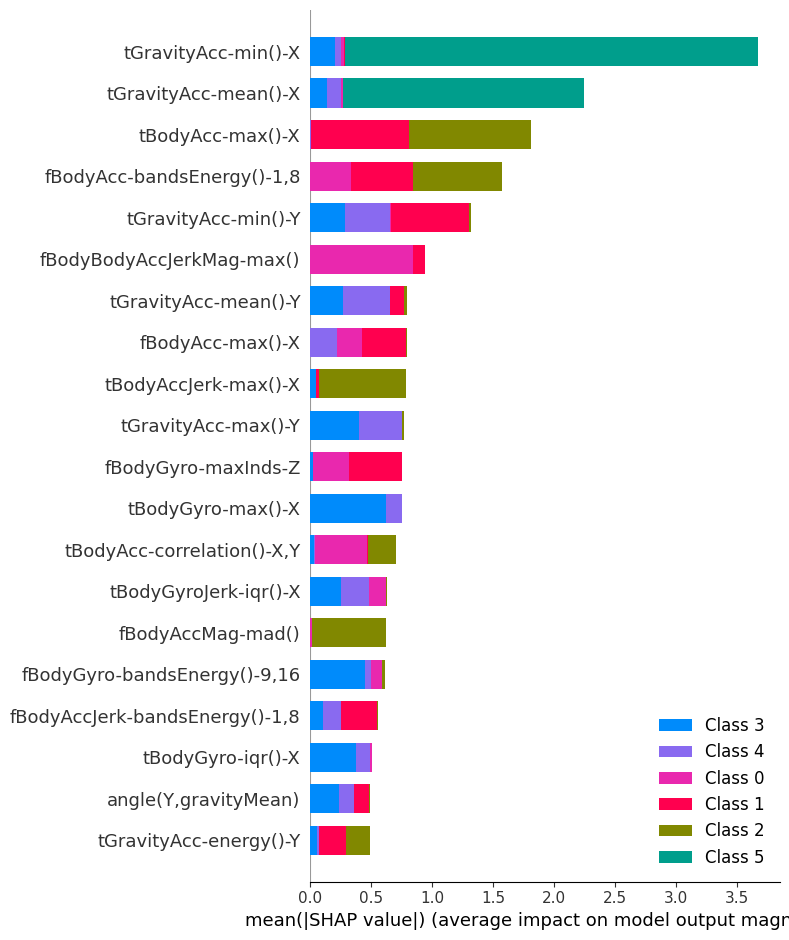

In [61]:

# 1. Отдельные массивы без дубликатов
X_train_nd = X_train[:, ~duplicating_mask]
X_test_nd  = X_test[:,  ~duplicating_mask]

# 2. Обучение XGBoost на «очищенных» данных
dtrain_nd = xgb.DMatrix(X_train_nd, label=y_train)
dtest_nd  = xgb.DMatrix(X_test_nd,  label=y_test)

# Используем те же оптимальные параметры
model_nd = xgb.train(best_params, dtrain_nd, num_boost_round=num_rounds)

# 3. Оценка качества
y_pred_nd = model_nd.predict(dtest_nd).argmax(axis=1)
from sklearn.metrics import accuracy_score
print("Accuracy без дубликатов:", accuracy_score(y_test, y_pred_nd))

# 4. SHAP-анализ на новых данных
explainer_nd = shap.TreeExplainer(model_nd)
shap_values_nd = explainer_nd.shap_values(X_test_nd)

# Beeswarm на очищенных данных
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values_nd, X_test_nd,
                  feature_names=[feature_labels[i+1] for i in range(n_features) if i not in duplicating_columns],
                  plot_type="dot", show=False, rng=0)
plt.tight_layout()
plt.show()

# Bar plot
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values_nd, X_test_nd,
                  feature_names=[feature_labels[i+1] for i in range(n_features) if i not in duplicating_columns],
                  plot_type="bar", show=False)
plt.tight_layout()
plt.show()

### Conclusion

Your thoughts about the plots and model behaviour (not limited to duplicating features):

**YOUR TEXT HERE**
# Выводы после удаления дубликатов

* Качество практически не изменилось (Accuracy без дубликатов ≈ 94%). Есть предоложение что модель XGb учитывает дубликаты.
* Возможно SHAP-графики стали чуть более «чистыми»
* Топ-признаки остались примерно те же (в частности, всё ещё лидирует tGravityAcc-min()-X).